# Evaluate Effect of Rotating Molecule
The vibrational frequencies of a molecule are invariant to rotation of the coordinate system, in theory.
In practice, computing the vibrational frequencies requires numerical derivatives performed in a specific coordinate system.
Here, we evaluate the effect of the choice of coordinate system.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jitterbug.compare import compare_hessians
from jitterbug.utils import make_calculator
from ase.vibrations import Vibrations
from ase.io import read
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil

Configuration

In [2]:
molecule_path = 'data/exact/caffeine_pm7_None.xyz'
num_samples: int = 256

Derived

In [3]:
molecule_path = Path(molecule_path)
molecule_name, method, basis = molecule_path.name[:-4].split("_")

## Load the Relaxed Geometry, Make Calculator
Prepare to run the Hessian computation

In [4]:
atoms = read(molecule_path)

In [5]:
calc = make_calculator(method, basis)
atoms.calc = calc

## Compute Hessian for the Original Orientation
We'll use this as the reference

In [6]:
def get_hessian(atoms) -> np.ndarray:
    """Compute the Hessian"""
    
    if Path('vib').exists():
        shutil.rmtree('vib')
    vib = Vibrations(atoms)
    vib.run()
    ref_hessian = vib.get_vibrations()
    return ref_hessian.get_hessian_2d()

In [7]:
%%time
ref_hessian = get_hessian(atoms)

CPU times: user 151 ms, sys: 696 ms, total: 847 ms
Wall time: 5.57 s


## Compute Hessian for Many Rotations, Measure Differences
We will measure the ZPE error and vibration MAE

In [8]:
comparisons = []
for i in tqdm(range(num_samples)):
    # Make a random rotation vector
    u = np.random.uniform(-1, 1)
    v = np.random.uniform(0, 2 * np.pi)
    v = (np.sqrt(1 - u ** 2) * np.cos(v), np.sqrt(1 - u ** 2) * np.sin(v), u)
    
    # Make a random rotation 
    atoms.rotate(np.random.uniform(0, 360), v)
    
    # Compute and compare hessian
    new_hessian = get_hessian(atoms)
    comparison = compare_hessians(atoms, ref_hessian, new_hessian)
    comparisons.append({
        'zpe_error': abs(comparison.zpe_error),
        'vib_mae': comparison.vib_mae
    })  

  0%|                                                                                                                                                                                                                                                             | 0/256 [00:00<?, ?it/s]/home/lward/miniconda3/envs/jitterbug/lib/python3.9/site-packages/pmutt/statmech/vib.py:87: RuntimeWarning: overflow encountered in sinh
  (0.5 * vib_dimless)**2 * (1. / np.sinh(vib_dimless / 2.))**2
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [30:09<00:00,  7.07s/it]


Compare for many samples

In [9]:
comparisons = pd.DataFrame(comparisons)
comparisons.describe()

,zpe_error,vib_mae
count,256.000000,256.000000
mean,0.008504,0.124474
std,0.004583,0.045956
min,0.000007,0.016011
25%,0.004681,0.088121
50%,0.008094,0.124565
75%,0.013257,0.168693
max,0.015370,0.219113


Text(0, 0.5, 'Frequency')

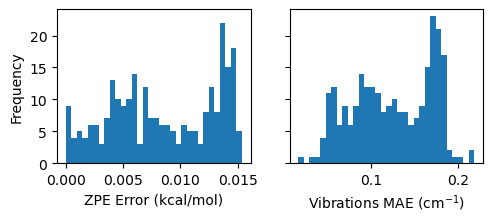

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharey=True)

for ax, c, t in zip(axs, ['zpe_error', 'vib_mae'], ['ZPE Error (kcal/mol)', 'Vibrations MAE (cm$^{-1}$)']):
    ax.hist(comparisons[c], bins=32)
    
    ax.set_xlabel(t)
    
axs[0].set_ylabel('Frequency')

Errors due to coordinate system are very small

In [11]:
out_dir = Path('data') / 'error-bounds' 
out_dir.mkdir(exist_ok=True)
comparisons.to_csv(out_dir / f'{molecule_path.name[:-4]}-rotations.csv', index=False)